In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

random_state = 42
np.random.seed(random_state)

In [2]:
# read the dataset
df = pd.read_csv('data/training_data.csv')
df

,timestamp,relation,train_number,delay,delay_cause
0,1667670796496,Szentendre - Batthyány tér,36H4001,0.740741,NaN
1,1667671043563,Batthyány tér - Szentendre,36H4008,0.095238,NaN
2,1667671914063,Szentendre - Batthyány tér,36H4011,0.444444,NaN
3,1667668077649,Batthyány tér - Szentendre,36H4012,3.000000,NaN
4,1667672285102,Batthyány tér - Szentendre,36H4018,0.333333,NaN
...,...,...,...,...,...
123499,1671363861961,Kecskemét - Budapest-Nyugati,552915,2.468354,Pálya állapota miatti késés
123500,1671133361699,Kőszeg - Szombathely,4339953,3.714286,NaN
123501,1671215187279,Kőszeg - Szombathely,4339953,2.692308,NaN
123502,1671315860737,Szombathely - Kőszeg,4339946,1.783784,NaN


In [3]:
# drop the delay column
df = df.drop(columns=['delay'])

# transform timestamp to hour
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x / 1000).hour)

# encode the non-numberic values
df['relation'] = df['relation'].apply(hash)
df['train_number'] = df['train_number'].apply(hash)
df['delay_cause'] = np.where(df['delay_cause'].isna(), 'no delay', df['delay_cause'])
categories = pd.Categorical(df['delay_cause'])
df['delay_cause'] = categories.codes

df

,timestamp,relation,train_number,delay_cause
0,18,-8316608025656241641,5194469685695334900,12
1,18,3565765696779938297,7377258454426981884,12
2,19,-8316608025656241641,-8574713757277637684,12
3,18,3565765696779938297,-452564781871375944,12
4,19,3565765696779938297,5875006874760008067,12
...,...,...,...,...
123499,12,-8793777263559184613,5427010928118964860,5
123500,20,-9197049920686776739,-6972836827124310979,12
123501,19,-9197049920686776739,-6972836827124310979,12
123502,23,-6500779829344725014,1442430597038702125,12


In [4]:
pd.Categorical(df['delay_cause']).categories

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [5]:
# split the dataset into 80% training and 10% test 10% validation set
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['delay_cause']), df.delay_cause, test_size=0.2, random_state=random_state)
#X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.5, random_state=random_state)

# normalize the values
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
#X_valid = scaler.transform(X_valid)
# the dataset is imbalanced, therefore we oversample to try to correct this
values, counts = np.unique(Y_train, return_counts=True)
print(pd.DataFrame({'values':values, 'counts':counts}))
ros = RandomOverSampler()
X_train, Y_train = ros.fit_resample(X_train, Y_train)
values, counts = np.unique(Y_train, return_counts=True)
print(pd.DataFrame({'values':values, 'counts':counts}))

    values  counts
0        0     250
1        1     972
2        2    1227
3        3     115
4        4     618
5        5    7999
6        6     123
7        7     147
8        8    2389
9        9     170
10      10    6195
11      11     153
12      12   78445
    values  counts
0        0   78445
1        1   78445
2        2   78445
3        3   78445
4        4   78445
5        5   78445
6        6   78445
7        7   78445
8        8   78445
9        9   78445
10      10   78445
11      11   78445
12      12   78445


In [6]:
# create a random forest classifier model
model = RandomForestClassifier(n_estimators=10, verbose=2, random_state=random_state, n_jobs=10)

# train the model
history = model.fit(X_train, Y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    3.5s remaining:    8.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    3.8s finished


In [7]:
# score the model between 0.0 and 1.0
score = model.score(X_test, Y_test)
score

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5181166754382414

In [8]:
# predict delay casuses using the trained model
predictions = history.predict(X_test)

rownames = categories.from_codes(predictions, categories=categories.categories)
colnames = categories.from_codes(Y_test, categories=categories.categories)
# create confusion matrix from true and predicted labels
conf = pd.crosstab(colnames, rownames, margins=True, normalize='index',)
# conf = conf.apply(lambda column: column / column.iloc[len(column)-1], axis=1)

# drop the margin
#conf = conf.drop(columns=['All'])
conf = conf.drop(conf.tail(1).index)

# show the confusion matrix
conf

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


col_0,Baleset miatti késés,Biztosítóberendezési hiba miatti késés,Csatlakozásra várás miatti késés,Felsővezetéki hiba miatti késés,Más vonat által okozott késés,Pálya állapota miatti késés,Pályaépítés miatti késés,Rongálás miatti késés,Társvasúttól átvett késés,Vasútüzemen kívülálló ok miatti késés,Vonat műszaki hibája miatti késés,Váltó meghibásodás miatti késés,no delay
row_0,,,,,,,,,,,,,
Baleset miatti késés,0.040000,0.120000,0.140000,0.000000,0.060000,0.140000,0.000000,0.040000,0.040000,0.060000,0.080000,0.040000,0.240000
Biztosítóberendezési hiba miatti késés,0.064777,0.125506,0.113360,0.040486,0.089069,0.093117,0.008097,0.052632,0.052632,0.048583,0.113360,0.028340,0.170040
Csatlakozásra várás miatti késés,0.024390,0.076220,0.317073,0.042683,0.070122,0.103659,0.024390,0.076220,0.036585,0.036585,0.082317,0.033537,0.076220
Felsővezetéki hiba miatti késés,0.083333,0.083333,0.111111,0.027778,0.083333,0.000000,0.000000,0.055556,0.111111,0.000000,0.166667,0.027778,0.250000
Más vonat által okozott késés,0.034286,0.097143,0.097143,0.034286,0.205714,0.080000,0.017143,0.040000,0.062857,0.074286,0.102857,0.028571,0.125714
Pálya állapota miatti késés,0.044332,0.072544,0.121914,0.031234,0.052897,0.316373,0.034761,0.072544,0.052393,0.054408,0.067506,0.031738,0.047355
Pályaépítés miatti késés,0.076923,0.115385,0.038462,0.000000,0.000000,0.076923,0.307692,0.038462,0.000000,0.076923,0.153846,0.000000,0.115385
Rongálás miatti késés,0.026316,0.026316,0.131579,0.026316,0.078947,0.210526,0.052632,0.078947,0.026316,0.026316,0.131579,0.026316,0.157895
Társvasúttól átvett késés,0.040293,0.058608,0.049451,0.029304,0.049451,0.047619,0.014652,0.031136,0.520147,0.027473,0.051282,0.049451,0.031136


In [9]:
print(classification_report(colnames, rownames, zero_division=0))

                                        precision    recall  f1-score   support

                  Baleset miatti késés       0.00      0.04      0.01        50
Biztosítóberendezési hiba miatti késés       0.02      0.13      0.03       247
      Csatlakozásra várás miatti késés       0.07      0.32      0.11       328
       Felsővezetéki hiba miatti késés       0.00      0.03      0.01        36
         Más vonat által okozott késés       0.02      0.21      0.04       175
           Pálya állapota miatti késés       0.37      0.32      0.34      1985
              Pályaépítés miatti késés       0.02      0.31      0.04        26
                 Rongálás miatti késés       0.01      0.08      0.01        38
             Társvasúttól átvett késés       0.20      0.52      0.29       546
 Vasútüzemen kívülálló ok miatti késés       0.00      0.00      0.00        37
     Vonat műszaki hibája miatti késés       0.16      0.18      0.17      1525
       Váltó meghibásodás miatti késés 

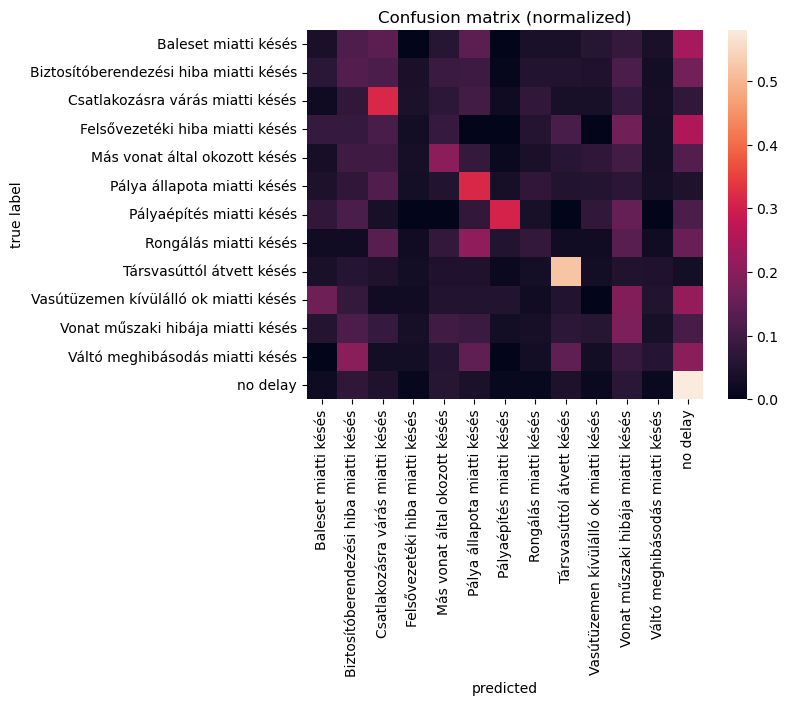

In [10]:
sns.heatmap(conf)
plt.ylabel('true label')
plt.xlabel('predicted')
plt.title('Confusion matrix (normalized)')
plt.show()